# **Импорт библиотек визуализации и настройка графиков**

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# **Определение вспомогательных функций**

In [2]:
class PiyavskyMethod:
    """
    Класс для реализации метода Пиявского (метода ломаных) для поиска глобального минимума.
    """

    def __init__(self, func: str, x_start: float, x_end: float, eps=0.01) -> None:
        """
        Инициализация метода Пиявского.

        Аргументы:
            func: строка с функцией (например, "x**2 + sin(x)")
            x_start: начало отрезка
            x_end: конец отрезка
            eps: точность решения
        """
        self.func_str = func
        self.x_start = x_start
        self.x_end = x_end
        self.eps = eps

        # Создаем вычислимую функцию
        self.func = self._create_function()

        # Вычисляем константу Липшица
        self.L = self._compute_lipschitz_constant()

        # Начальные точки - границы отрезка
        self.points = [
            (self.x_start, self.func(self.x_start)),
            (self.x_end, self.func(self.x_end))
        ]

        # Кэш для ускорения вычислений
        self.intersection_cache = {}
        self.iteration_count = 0

    def _create_function(self):
        """Создает вычислимую функцию из строки."""
        # Очищаем строку от f(x)=
        expr = self.func_str.replace("f(x)=", "").strip()

        # Создаем безопасную функцию
        def safe_func(x):
            return eval(expr, {"math": math, "np": np, "x": x})

        return safe_func

    def _compute_lipschitz_constant(self) -> float:
        """Вычисляет константу Липшица численным методом."""
        n_samples = 2000
        x_vals = np.linspace(self.x_start, self.x_end, n_samples)
        h = x_vals[1] - x_vals[0]

        max_derivative = 0

        for x in x_vals:
            if x - h >= self.x_start and x + h <= self.x_end:
                # Численное вычисление производной
                derivative = (self.func(x + h) - self.func(x - h)) / (2 * h)
                max_derivative = max(max_derivative, abs(derivative))

        # Добавляем запас 20% для надежности
        return max_derivative * 1.2

    def _find_intersection(self, x1: float, y1: float, x2: float, y2: float) -> tuple[float, float]:
        """Находит точку пересечения двух вспомогательных функций."""
        cache_key = (x1, x2)

        if cache_key in self.intersection_cache:
            return self.intersection_cache[cache_key]

        # Формула точки пересечения для метода Пиявского
        x_intersect = ((y1 - y2) / (2 * self.L)) + ((x1 + x2) / 2)
        y_intersect = y1 - self.L * (x_intersect - x1)

        self.intersection_cache[cache_key] = (x_intersect, y_intersect)
        return x_intersect, y_intersect

    def _find_next_point(self) -> tuple[float, float]:
        """Находит следующую точку для исследования."""
        best_x = None
        best_lower_bound = float('inf')
        best_interval = None

        # Ищем интервал с наименьшей нижней оценкой
        for i in range(len(self.points) - 1):
            x1, y1 = self.points[i]
            x2, y2 = self.points[i + 1]

            x_intersect, y_intersect = self._find_intersection(x1, y1, x2, y2)

            if y_intersect < best_lower_bound:
                best_lower_bound = y_intersect
                best_x = x_intersect
                best_interval = (x1, x2)

        # Удаляем использованный интервал из кэша
        if best_interval in self.intersection_cache:
            del self.intersection_cache[best_interval]

        return best_x, best_lower_bound

    def step(self) -> bool:
        """Выполняет одну итерацию метода."""
        self.iteration_count += 1

        # Находим новую точку
        x_new, lower_bound = self._find_next_point()

        # Вычисляем значение функции в новой точке
        y_new = self.func(x_new)

        # Добавляем точку и сортируем
        self.points.append((x_new, y_new))
        self.points.sort(key=lambda p: p[0])

        # Проверяем условие остановки
        current_min = min(p[1] for p in self.points)
        gap = current_min - lower_bound

        return gap < self.eps

    def solve(self, max_iterations=5000) -> tuple[float, float]:
        """
        Решает задачу оптимизации.

        Возвращает:
            (x_min, f_min) - координаты найденного минимума
        """
        for _ in range(max_iterations):
            if self.step():
                break

        return min(self.points, key=lambda p: p[1])

    def solve_for_iterations(self, n_iterations: int) -> tuple[float, float]:
        """Выполняет заданное количество итераций."""
        for _ in range(n_iterations):
            self.step()

        return min(self.points, key=lambda p: p[1])

    def plot(self, show_solution=True, save_path=None) -> None:
        """Строит график функции и процесса оптимизации."""
        # Точки для гладкого графика функции
        x_smooth = np.linspace(self.x_start, self.x_end, 1000)
        y_smooth = [self.func(x) for x in x_smooth]

        plt.figure(figsize=(12, 8))

        # График исходной функции
        plt.plot(x_smooth, y_smooth, 'b-', linewidth=2.5,
                label='Исходная функция f(x)', alpha=0.8, zorder=5)

        if show_solution:
            # Подготовка данных для ломаной
            x_polyline = []
            y_polyline = []

            for i in range(len(self.points) - 1):
                x1, y1 = self.points[i]
                x2, y2 = self.points[i + 1]

                # Добавляем левую точку
                x_polyline.append(x1)
                y_polyline.append(y1)

                # Добавляем точку пересечения
                x_intersect, y_intersect = self._find_intersection(x1, y1, x2, y2)
                x_polyline.append(x_intersect)
                y_polyline.append(y_intersect)

            # Добавляем последнюю точку
            x_polyline.append(self.points[-1][0])
            y_polyline.append(self.points[-1][1])

            # Ломаная Пиявского
            plt.plot(x_polyline, y_polyline, 'r--', linewidth=1.5,
                    label='Ломаная Пиявского', alpha=0.7, zorder=10)

            # Вычисленные точки
            x_points = [p[0] for p in self.points]
            y_points = [p[1] for p in self.points]
            plt.scatter(x_points, y_points, color='red', s=40,
                       alpha=0.6, zorder=15, label='Точки вычислений')

            # Лучшая точка
            best_x, best_y = min(self.points, key=lambda p: p[1])
            plt.scatter([best_x], [best_y], color='green', s=150,
                       marker='*', zorder=20,
                       label=f'Найденный минимум: f({best_x:.4f}) = {best_y:.4f}')

        # Настройка графика
        plt.xlabel('x', fontsize=14, fontweight='bold')
        plt.ylabel('f(x)', fontsize=14, fontweight='bold')

        if show_solution:
            title = f'Метод Пиявского (итерация {self.iteration_count})'
        else:
            title = 'График функции'
        plt.title(title, fontsize=16, fontweight='bold', pad=20)

        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(loc='upper right', framealpha=0.9)

        # Добавляем оси координат
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен как {save_path}")

        plt.show()

    def get_statistics(self) -> dict:
        """Возвращает статистику по выполнению метода."""
        best_x, best_y = min(self.points, key=lambda p: p[1])

        return {
            'x_min': best_x,
            'f_min': best_y,
            'iterations': self.iteration_count,
            'points_evaluated': len(self.points),
            'lipschitz_constant': self.L,
            'search_interval': (self.x_start, self.x_end)
        }


# Вспомогательная функция для запуска тестов
def run_piyavsky_test(func_str, x_start, x_end, eps=0.01, max_iterations=5000, plot=True):
    """
    Запускает метод Пиявского для заданной функции и возвращает результаты.

    Аргументы:
        func_str: строка с функцией
        x_start, x_end: границы отрезка
        eps: точность
        max_iterations: максимальное число итераций
        plot: строить ли график

    Возвращает:
        словарь с результатами
    """
    print("=" * 60)
    print(f"Запуск метода Пиявского")
    print("=" * 60)

    start_time = time.time()

    # Создаем и запускаем метод
    optimizer = PiyavskyMethod(func_str, x_start, x_end, eps)
    initialization_time = time.time() - start_time

    start_time = time.time()
    x_min, f_min = optimizer.solve(max_iterations)
    solution_time = time.time() - start_time


    # Строим график
    if plot:
        optimizer.plot()

    return {
        'optimizer': optimizer,
        'statistics': stats,
        'timing': {
            'initialization': initialization_time,
            'solution': solution_time,
            'total': initialization_time + solution_time
        }
    }

### **Описание ячейки кода**

Краткое содержимое первой строки кода:


In [3]:


# Определение тестовых случаев
test_1 = ("f(x)=2*x - math.sin(math.pi*x) + math.cos(math.pi*x)", -1.5, 1.5, 0.01)

test_2 = ("f(x)=-180*math.cos(math.sqrt(abs(x/2+210)))-x*math.sin(math.sqrt(abs(x-150)))", -450, -100, 0.01)

test_3 = ("f(x)=math.sqrt(x)*math.cos(1.5*x)", 0.5, 9, 0.01)

test_4 = ("f(x)=math.sqrt(1+4*math.sin(x)**2)+math.cos(9*x)", 0.5, 5.5, 0.01)

test_5 = ("f(x)=95+math.sin(8*x)", 0.5, 3.5, 0.01)

# Функция Растригина
test_6 = ("f(x)=12+x**2-12*math.cos(2*math.pi*x)", -2.5, 2.5, 0.01)

# Функция Экли
test_7 = ("f(x)=-18*math.exp(-0.25*math.sqrt(x**2))-math.exp(math.sin(2*math.pi*x))+22+math.exp(1)", -3, 3, 0.01)

test_8 = ("f(x)=abs(math.cos(2.5*x))+0.4*abs(math.sin(4*x))", -2, 2, 0.01)

test_9 = ("f(x)=math.cos(x)+0.25*math.sin(7*x)+0.1*math.cos(35*x)+0.03*x**2", -4, 4, 0.01)

test_10 = ("f(x)=math.tanh(9*(x-1))-math.tanh(9*(x+1))+0.4*math.cos(3*x)", -2.5, 2.5, 0.01)

test_11 = ("f(x)=0.6*(math.cos(12*x)/(12*x)+1)+0.15*math.sin(3*x)+0.07*x", 0.1, 4, 0.01)

test_12 = ("f(x)=math.cos(3*x)*math.exp(-0.6*abs(x))+0.2*math.sin(12*x)*math.exp(-0.4*abs(x-1))+0.05*x", -2.5, 4.5, 0.01)

test 1 : $$f_1(x) = 2x - \sin(\pi x) + \cos(\pi x)$$
test 2 : $$f_2(x) = -180 \cos\Big(\sqrt{|x/2 + 210|}\Big) - x \sin\Big(\sqrt{|x - 150|}\Big)$$
test 3 : $$f_3(x) = \sqrt{x} \cdot \cos(1.5 x)$$
test 4 : $$f_4(x) = \sqrt{1 + 4 \sin^2(x)} + \cos(9x)$$
test 5 : $$f_5(x) = 95 + \sin(8x)$$
test 6 : $$f_6(x) = 12 + x^2 - 12 \cos(2\pi x)$$
test 7 : $$f_7(x) = -18 \exp\Big(-0.25 \sqrt{x^2}\Big) - \exp(\sin(2\pi x)) + 22 + e$$
test 8 : $$f_8(x) = |\cos(2.5 x)| + 0.4 |\sin(4x)|$$
test 9 : $$f_9(x) = \cos(x) + 0.25 \sin(7x) + 0.1 \cos(35x) + 0.03 x^2$$
test 10 : $$f_{10}(x) = \tanh(9(x-1)) - \tanh(9(x+1)) + 0.4 \cos(3x)$$
test 11 : $$f_{11}(x) = 0.6 \left(\frac{\cos(12x)}{12x}+1\right) + 0.15 \sin(3x) + 0.07 x$$
test 12 : $$f_{12}(x) = \cos(3x) e^{-0.6 |x|} + 0.2 \sin(12x) e^{-0.4 |x-1|} + 0.05 x$$

# **### Определение вспомогательных функций**

In [5]:
def main(test, target_iterations=None):
    """
    Запускает метод Пиявского для заданного теста.
    Аргументы:
        test: Кортеж с параметрами теста (func, x_start, x_end, eps)
        target_iterations: Если указано, выполняется заданное количество итераций.
                          Если None, выполняется до достижения точности.
    """
    func = test[0]
    x_start = test[1]
    x_end = test[2]
    eps = test[3]

    # Создание экземпляра класса (время на вычисление константы Липшица)
    start_time = time.time()
    pm = PiyavskyMethod(func, x_start, x_end, eps)
    init_time = time.time() - start_time

    # Выполнение алгоритма
    start_time = time.time()
    if target_iterations is not None:
        x_min, f_min = pm.solve_for_iterations(target_iterations)
        solve_time = time.time() - start_time
        print(f"Найденный минимум: f({x_min})={f_min}")
        print(f"Число итераций: {target_iterations}")
    else:
        x_min, f_min = pm.solve()
        solve_time = time.time() - start_time
        print(f"Найденный минимум: f({x_min})={f_min}")
        print(f"Число итераций: {pm.iteration_count}")

    total_time = init_time + solve_time
    print(f"Время инициализации: {init_time:.4f} секунд")
    print(f"Время решения: {solve_time:.4f} секунд")
    print(f"Общее время: {total_time:.4f} секунд")

    pm.plot()


# **Основной цикл алгоритма**

Реализация итеративной части метода поиска глобального экстремума.


Тест 1
Найденный минимум: f(-1.3980457679611595)=-4.0600830124988505
Число итераций: 78
Время инициализации: 0.0908 секунд
Время решения: 0.0038 секунд
Общее время: 0.0946 секунд


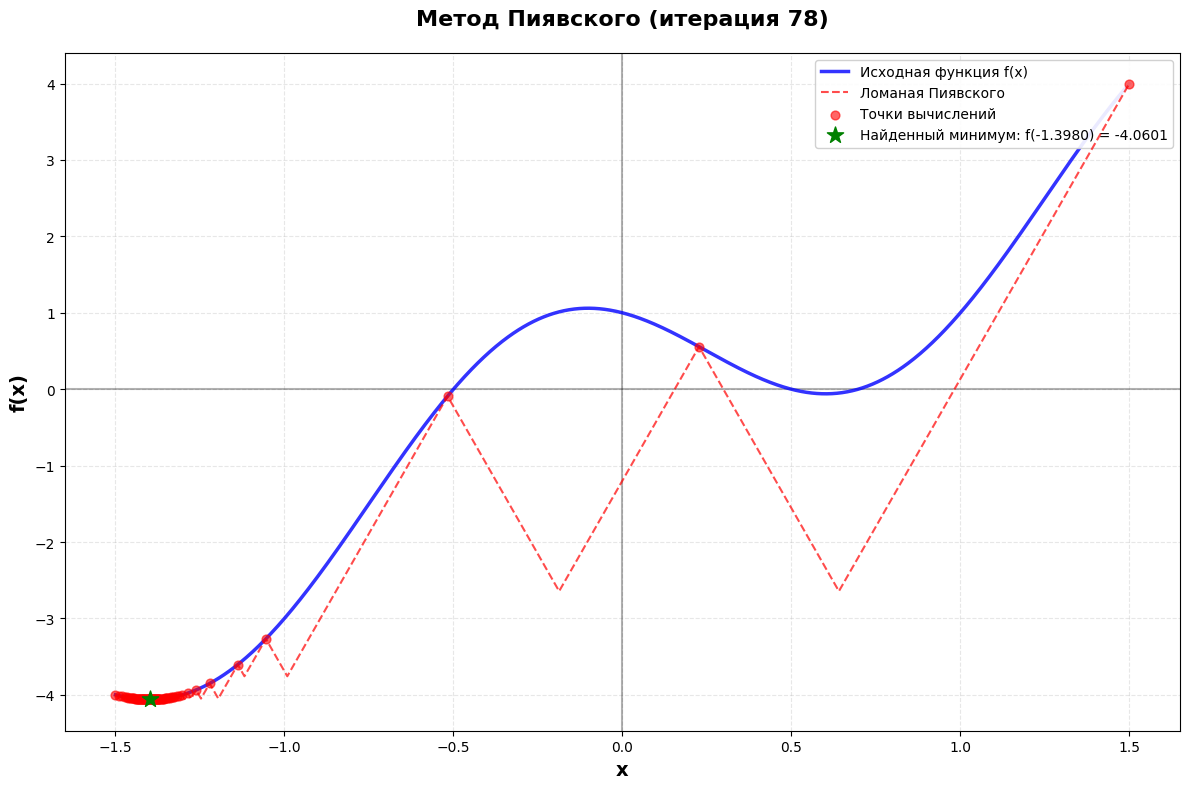



Тест 2
Найденный минимум: f(-419.99999999999756)=-579.6291041874224
Число итераций: 66
Время инициализации: 0.1389 секунд
Время решения: 0.0037 секунд
Общее время: 0.1427 секунд


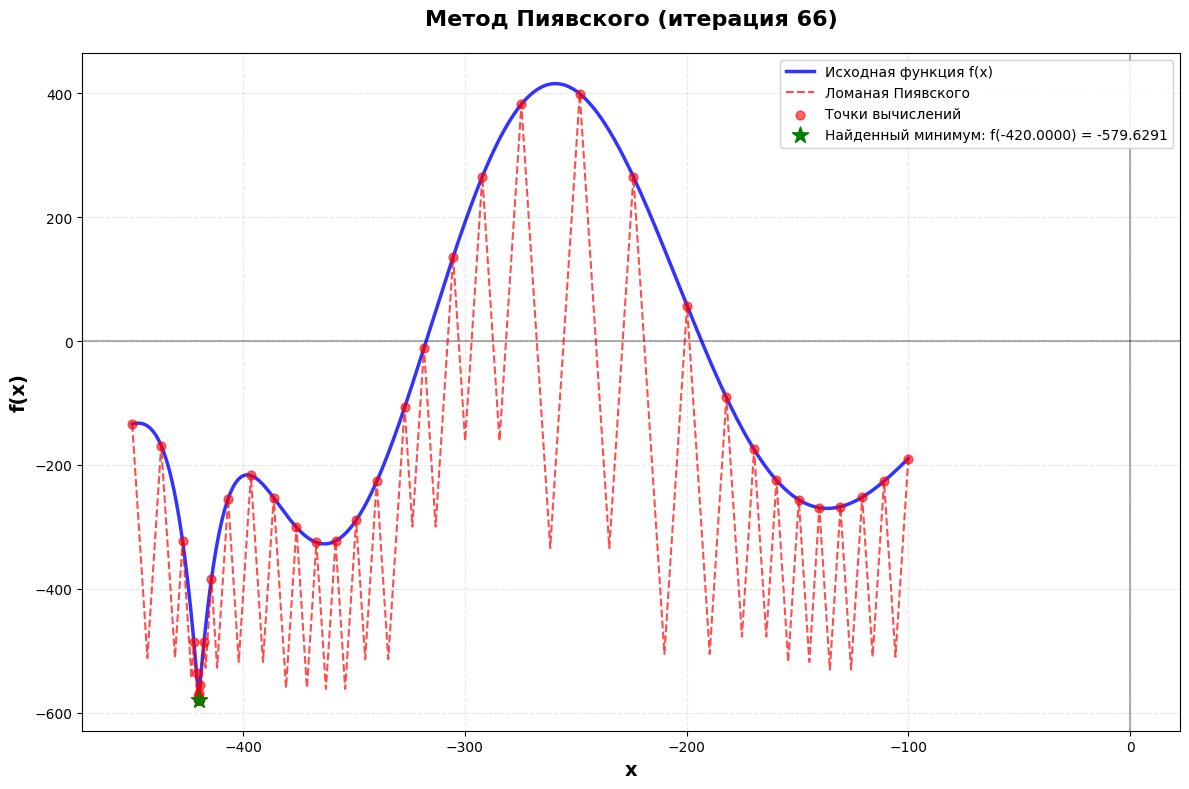



Тест 3
Найденный минимум: f(6.318322613790657)=-2.5101368641560065
Число итераций: 1738
Время инициализации: 0.0781 секунд
Время решения: 0.9276 секунд
Общее время: 1.0057 секунд


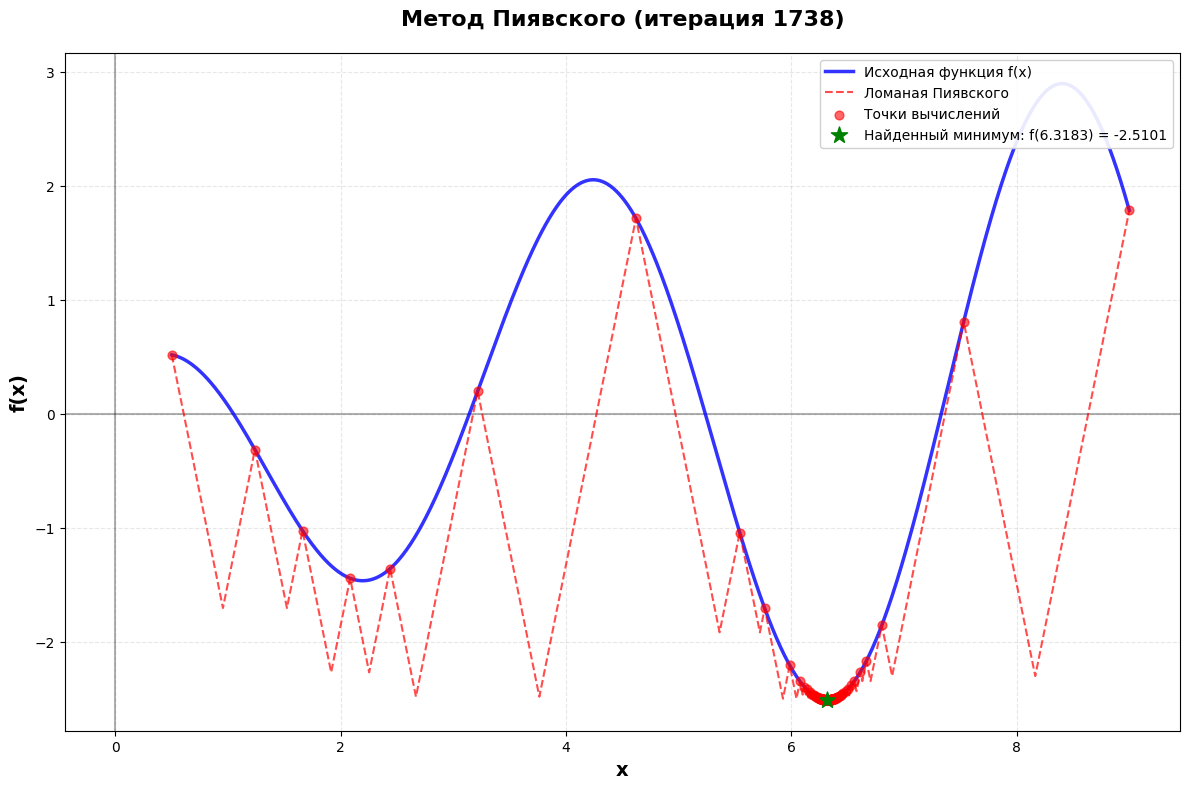



Тест 4
Найденный минимум: f(3.141722796387274)=7.198286996468184e-07
Число итераций: 94
Время инициализации: 0.1004 секунд
Время решения: 0.0053 секунд
Общее время: 0.1057 секунд


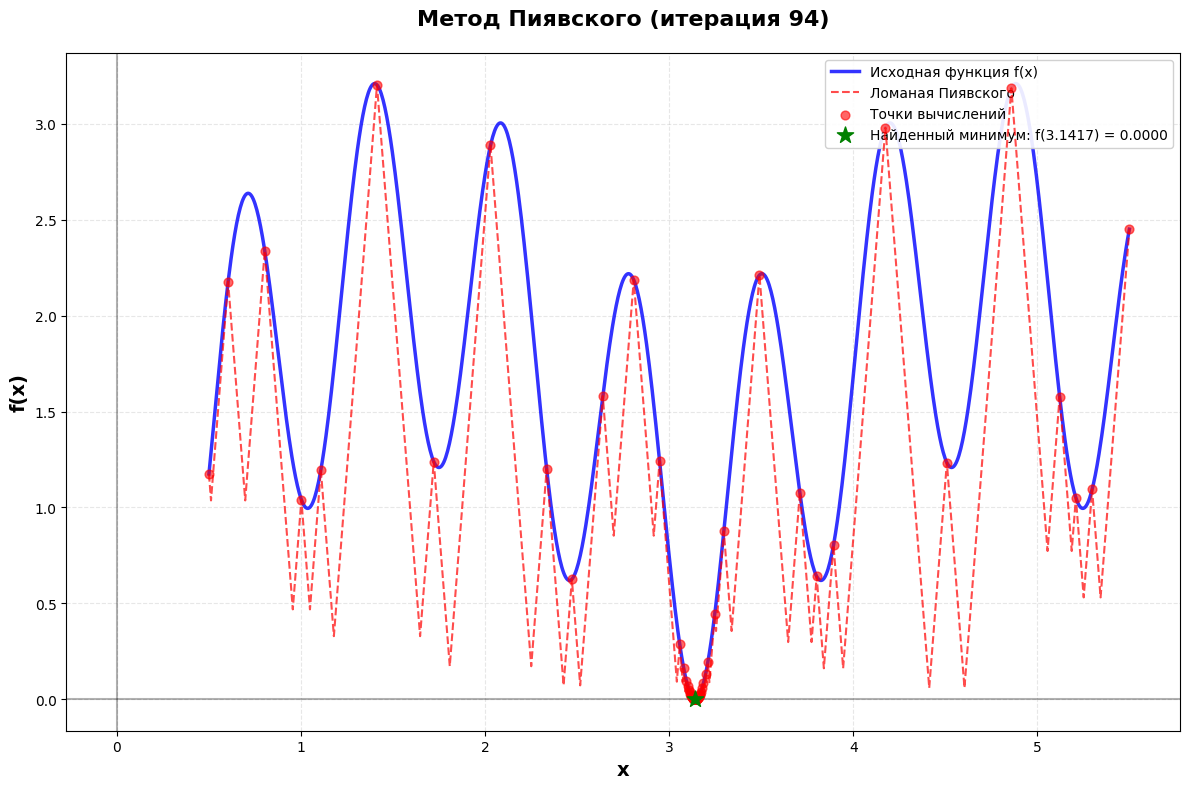



Тест 5
Найденный минимум: f(2.160439902594674)=94.00001132699852
Число итераций: 114
Время инициализации: 0.0673 секунд
Время решения: 0.0105 секунд
Общее время: 0.0779 секунд


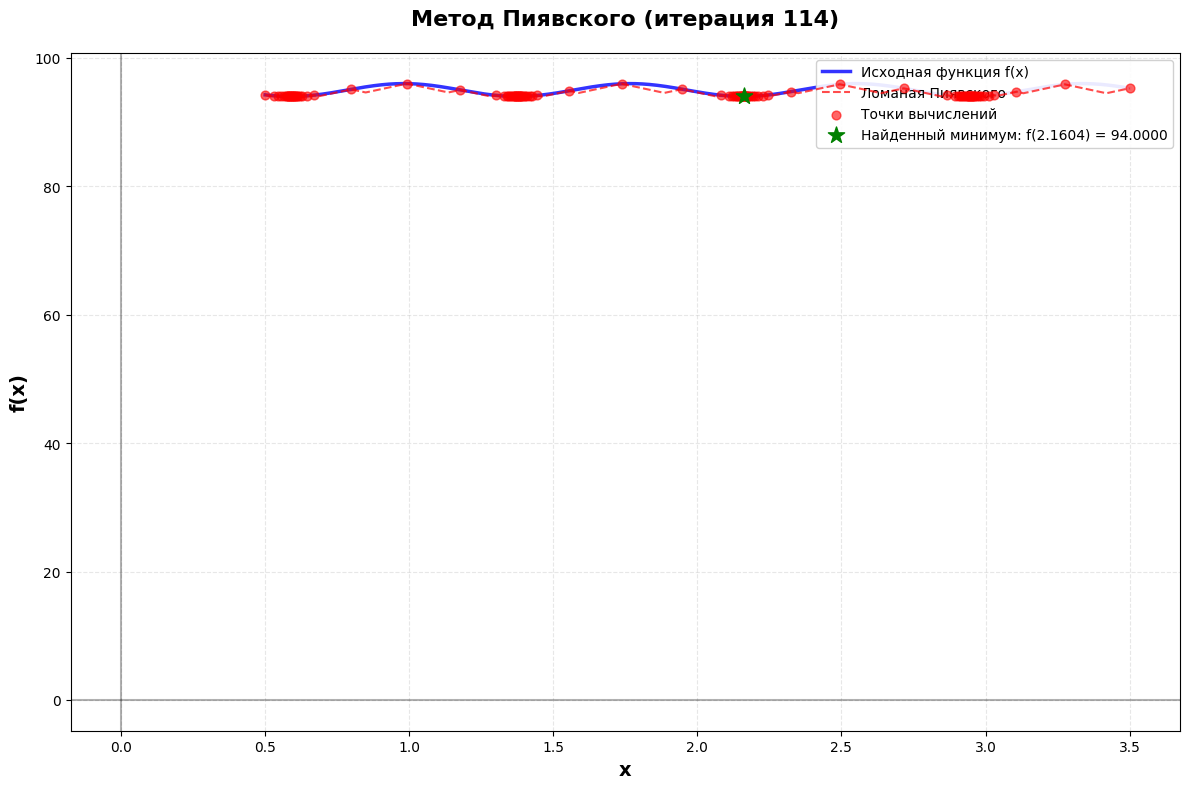



Тест 6
Найденный минимум: f(0.0)=0.0
Число итераций: 28
Время инициализации: 0.0875 секунд
Время решения: 0.0010 секунд
Общее время: 0.0885 секунд


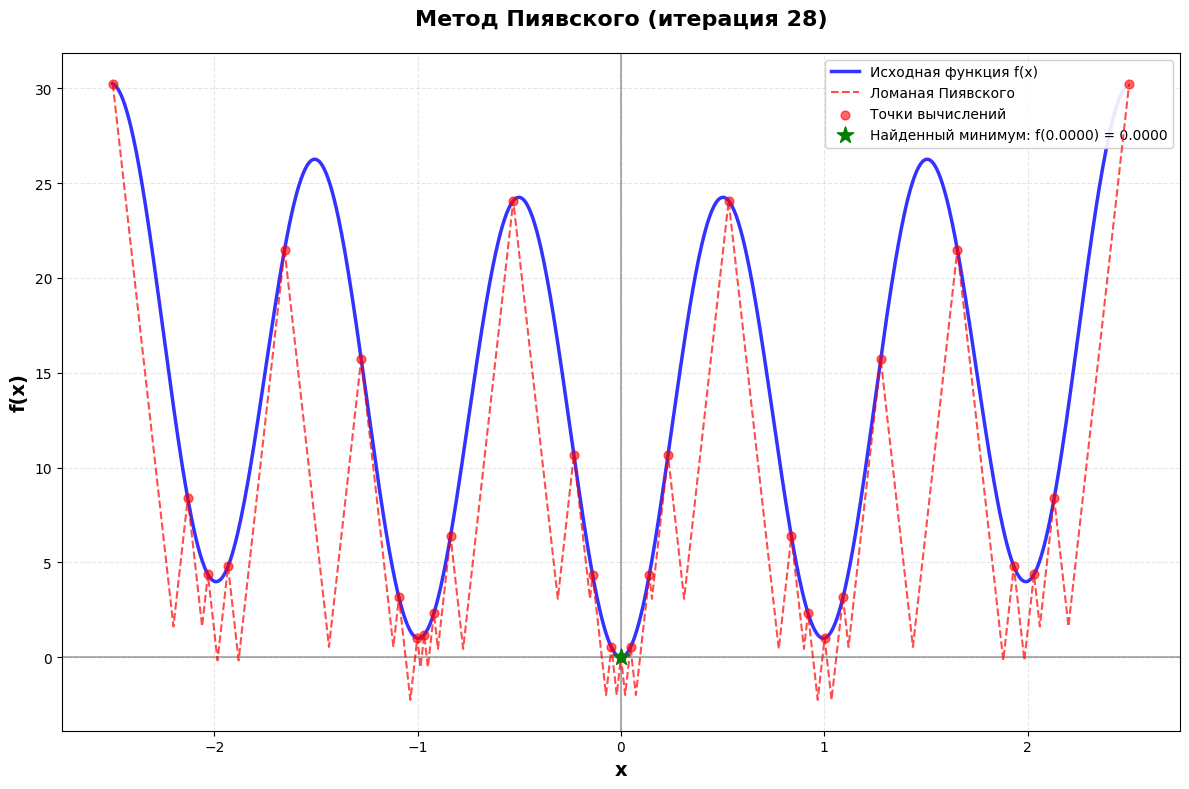



Тест 7
Найденный минимум: f(0.20834249804848232)=5.004567276812203
Число итераций: 176
Время инициализации: 0.1515 секунд
Время решения: 0.0154 секунд
Общее время: 0.1669 секунд


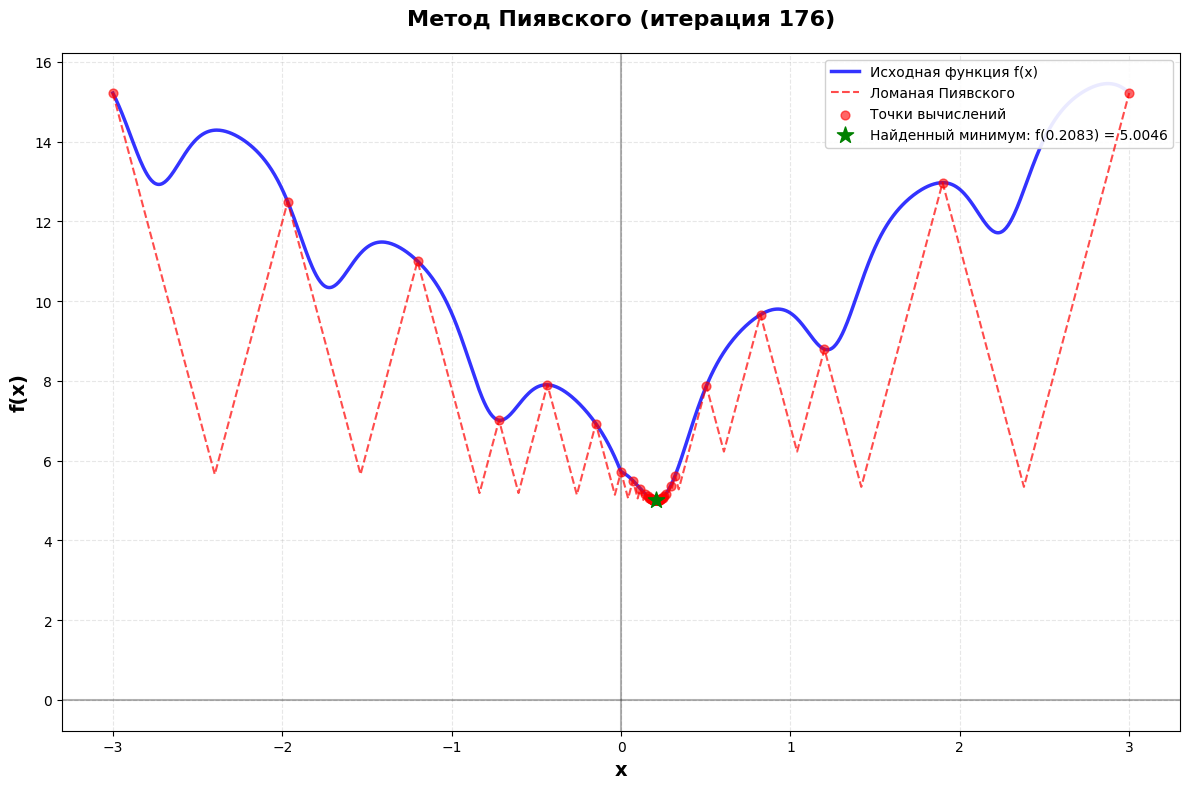



Тест 8
Найденный минимум: f(-0.6329931675458865)=0.2407087016109979
Число итераций: 36
Время инициализации: 0.1353 секунд
Время решения: 0.0015 секунд
Общее время: 0.1368 секунд


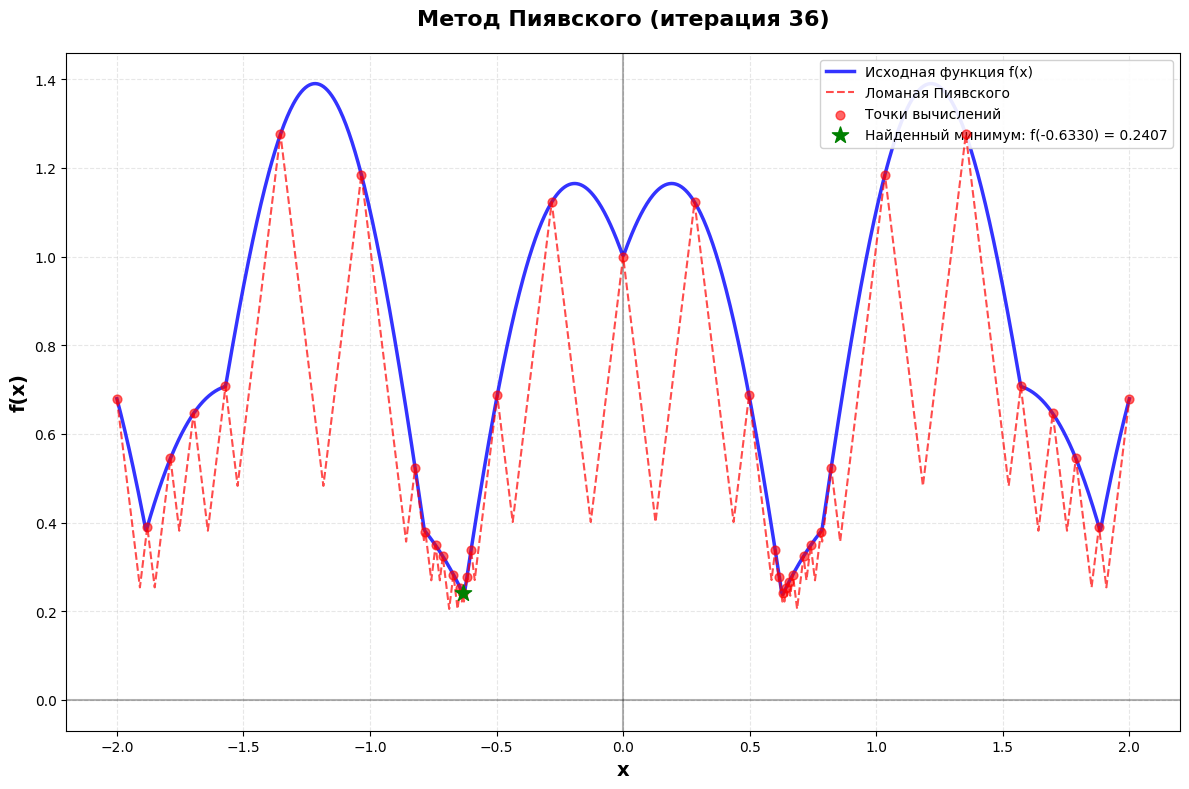



Тест 9
Найденный минимум: f(-2.9582297298305753)=-1.0595552356148223
Число итераций: 94
Время инициализации: 0.1318 секунд
Время решения: 0.0060 секунд
Общее время: 0.1378 секунд


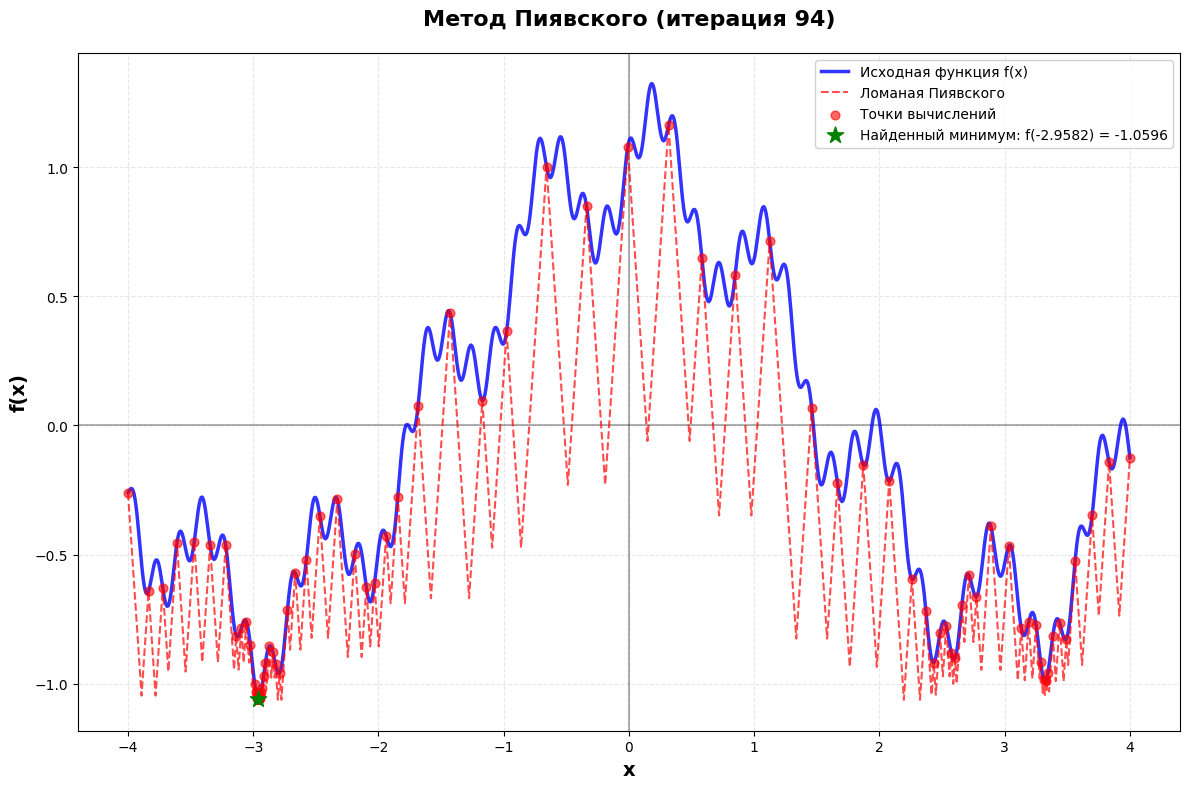



Тест 10
Найденный минимум: f(-0.7935843889900553)=-2.2421725749668813
Число итераций: 160
Время инициализации: 0.1405 секунд
Время решения: 0.0123 секунд
Общее время: 0.1528 секунд


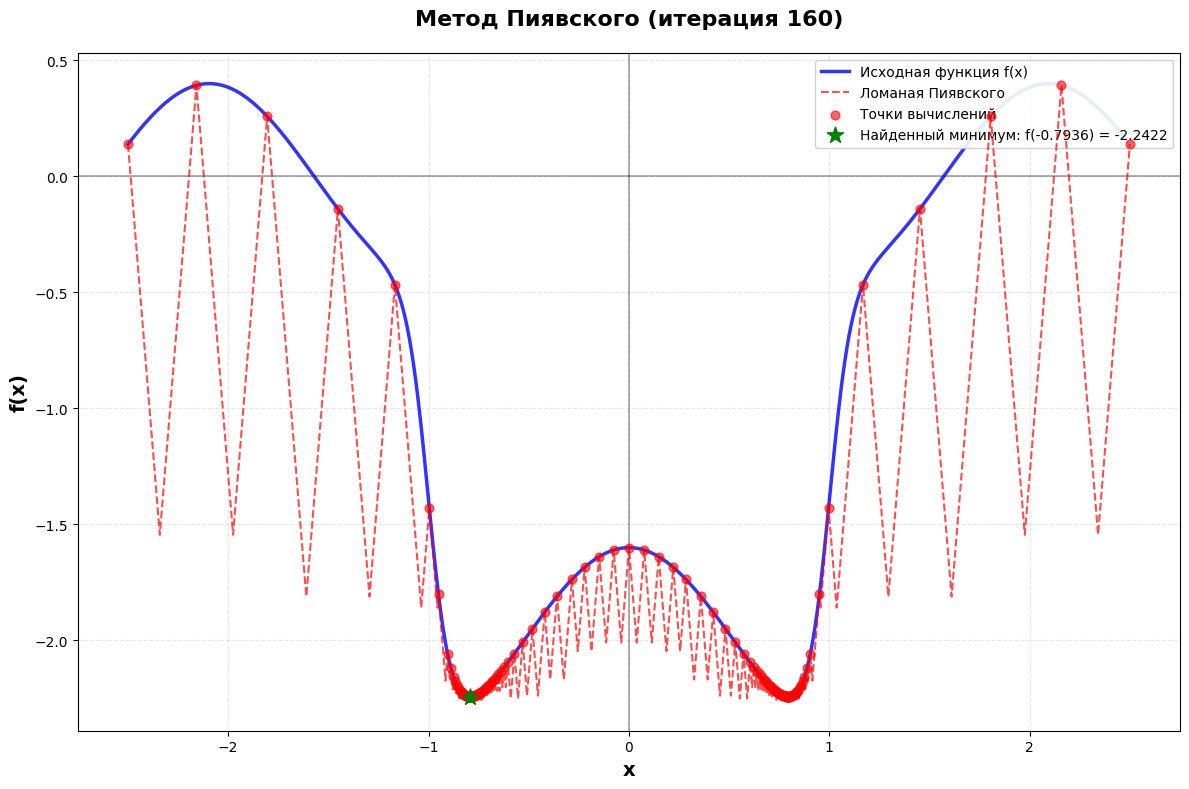



Тест 11
Найденный минимум: f(0.22247834696650673)=0.5082364758083435
Число итераций: 100
Время инициализации: 0.1398 секунд
Время решения: 0.0062 секунд
Общее время: 0.1460 секунд


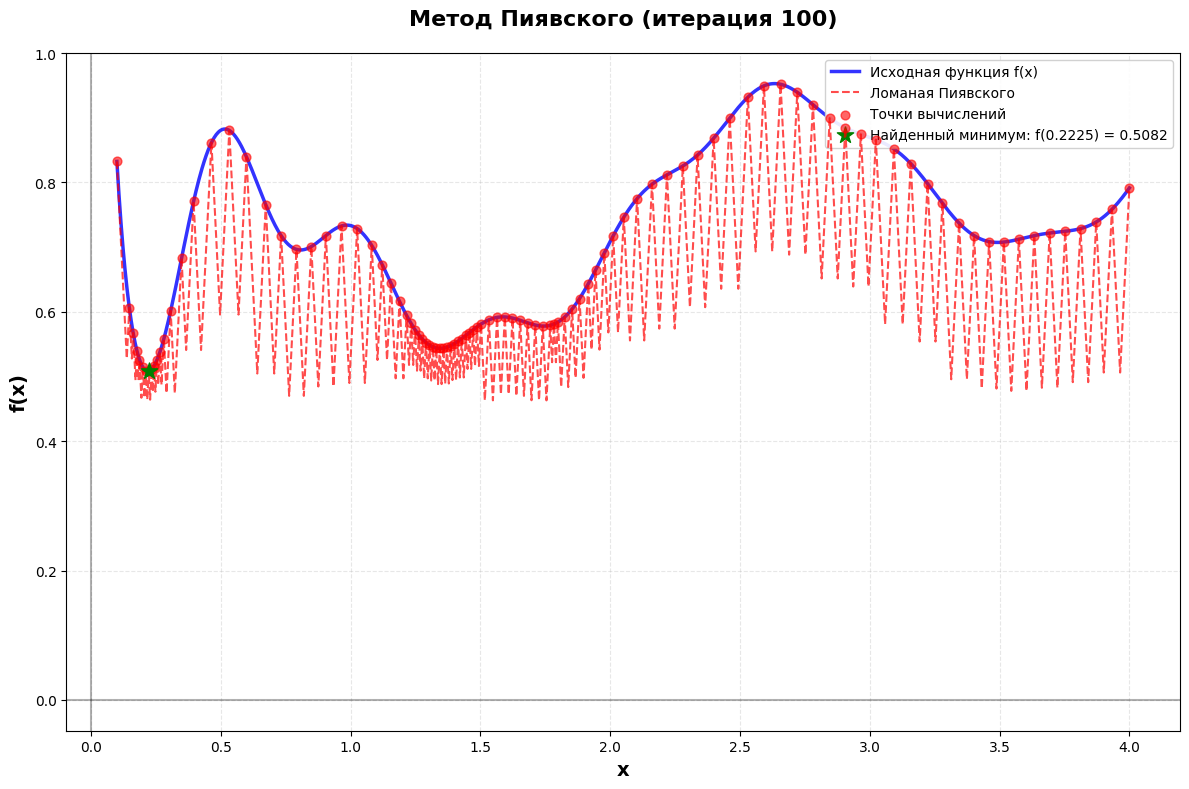



Тест 12
Найденный минимум: f(0.9273951251203311)=-0.6828058007765954
Число итераций: 120
Время инициализации: 0.1782 секунд
Время решения: 0.0093 секунд
Общее время: 0.1874 секунд


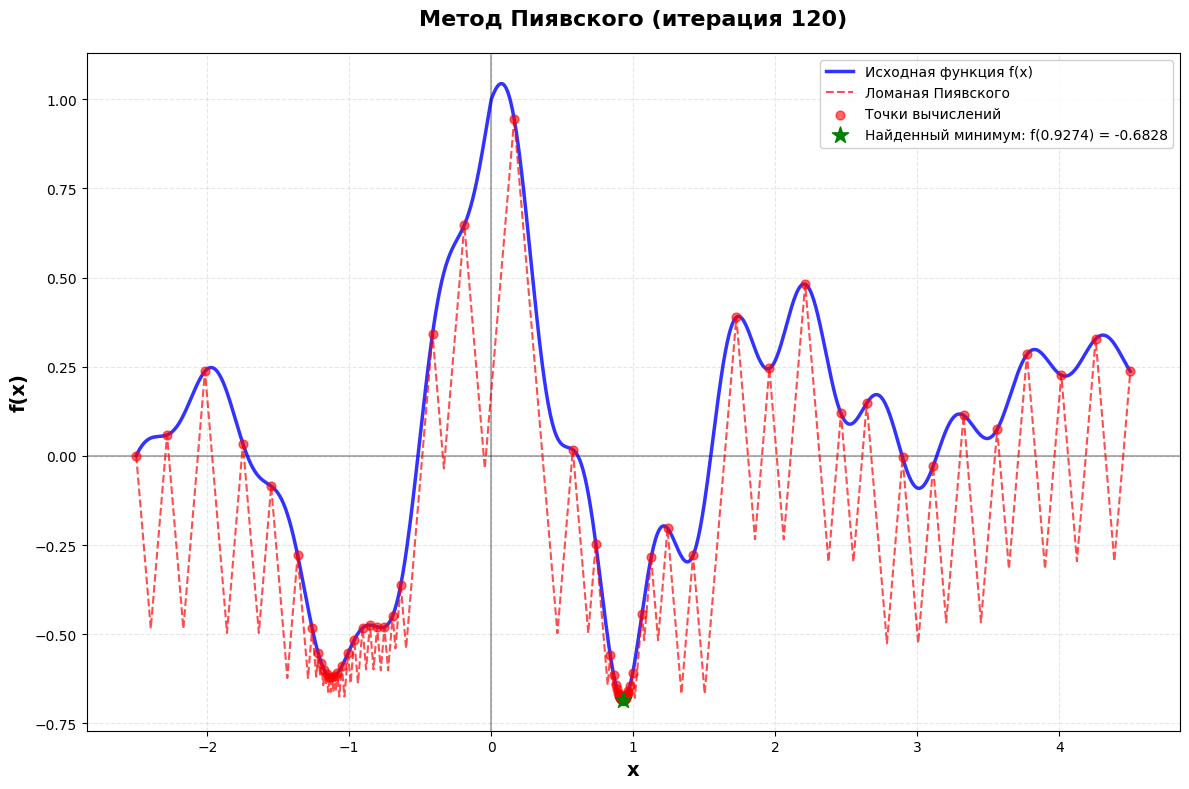

In [8]:
test_iterations = {
    'test_1': 78,
    'test_2': 66,
    'test_3': 1738,
    'test_4': 94,
    'test_5': 114,
    'test_6': 28,
    'test_7': 176,
    'test_8': 36,
    'test_9': 94,
    'test_10': 160,
    'test_11': 100,
    'test_12': 120
}

# Запуск всех тестов с заданным количеством итераций
tests = [test_1, test_2, test_3, test_4, test_5, test_6, test_7, test_8, test_9, test_10, test_11, test_12]

for i, test in enumerate(tests, 1):
    print(f"\n{'='*60}")
    print(f"Тест {i}")
    print(f"{'='*60}")
    iterations = test_iterations[f'test_{i}']
    main(test, target_iterations=iterations)
    print()

## Запуск отдельного теста


Найденный минимум: f(0.0)=0.0
Число итераций: 2
Время инициализации: 0.0820 секунд
Время решения: 0.0001 секунд
Общее время: 0.0821 секунд


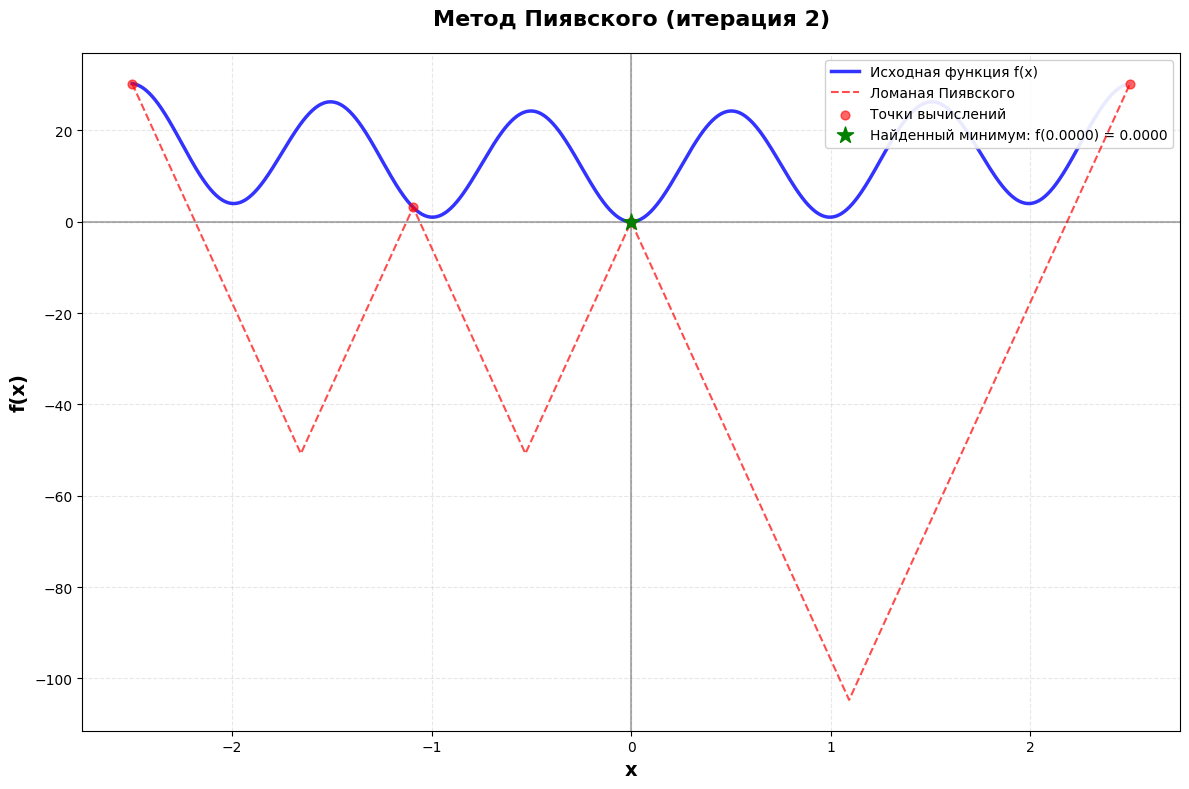

In [10]:
# Пример: запуск одного теста с заданным количеством итераций
# main(test_1, target_iterations=78)
# main(test_4, target_iterations=66)
main(test_6, target_iterations=2)
# и т.д.

# Или запуск до достижения точности (без указания итераций):
# main(test_11)